## Singular Value Decomposition (SVD): Term-Document Matrix

In this assignment, you will generate a term-document matrix from a small corpus of documents and then create a collection of synthetic documents that are similar to the original documents.

### Dataset Description
You are provided a collection of CSV files, named `processed_text_1.csv` to `processed_text_12.csv`. Each CSV file is a cleaned collection of words extracted from a series of Data Science lectures. Each row in a file represents a single sentence from the lecture transcripts.

As an example, "Data that has the format of a dictionary" is cleaned to "datum,format,dictionary" (the third row in `processed_text_12.csv`).

### Tasks

1. **Load the Data**: Read all the CSV files and create a Pandas DataFrame of two columns: `document_id` and `text`. The `document_id` should be the filename (e.g., `processed_text_1.csv`), and the `text` should be all sentences in that file concatenated into a single string.
2. **Create Term-Document Matrix**: Using `CountVectorizer` from `sklearn`, create a term-document matrix from the DataFrame. Each row should represent a document, and each column should represent a unique term from the corpus.
3. **Normalize the Matrix**: Normalize the frequency counts in the term-document matrix using L2 normalization. Namely, for each document vector (row), divide each term frequency by the Euclidean norm of that vector.
   $$ \text{Normalized\_tf}_{i,j} = \frac{\text{tf}_{i,j}}{\sqrt{\sum_{k} \text{tf}_{i,k}^2}} $$
4. **Generate A Synthetic Document**: Define the similarity score between two documents as the dot product of their normalized term frequency vectors. 
   $$ \text{similarity}(D_a, D_b) = \sum_{j} \text{Normalized\_tf}_{a,j} \times \text{Normalized\_tf}_{b,j} $$
   Create a synthetic document (row vector) such that it maximizes the sum of squred similarities to all original documents. Formally, find a vector \( S \) that maximizes:
   $$ \text{Objective}(S) = \sum_{i} \left( \sum_{j} S_j \times \text{Normalized\_tf}_{i,j} \right)^2 $$
5. **Compute Centeroid Document**: Compute the centroid document vector by averaging the normalized term frequency vectors of all original documents.
   $$ \text{Centroid}_j = \frac{1}{N} \sum_{i} \text{Normalized\_tf}_{i,j} $$
6. **Compare Synthetic Document to Centroid**: Calculate the similarity score between the synthetic document and the centroid document using the defined similarity measure.
7. **Generate Synthetic Documents**: Create $k$ ($k<N$) synthetic documents that maximize the objective function while being orthogonal to each other. 
8. **Plot Similarity Scores**: For each synthetic document generated in step 7, compute and plot the sum of squared similarities to all original documents.
9. **Plot Synthetic Documents**: Use PCA to reduce the dimensionality of the original documents to 2D and plot both the original documents, the synthetic documents, and the centroid document on the same plot for visualization.

### Setup Code

In [1]:
import pandas as pd
import numpy as np
import os
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def load_data(folder_path):
    """
    Load all CSV files from a folder into a single DataFrame.
    IN: folder_path, str, path to the folder containing CSV files
    OUT: df, pd.DataFrame, with 'document_id' and 'text' columns
    """
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            # Read the csv, each row is a sentence fragment
            words = []
            with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                for row in reader:
                    words.extend(row)
            # Concatenate all text fragments into a single string for the document
            text = ' '.join(words)
            data.append({'document_id': filename, 'text': text})
    
    df = pd.DataFrame(data)
    return df

In [3]:
if __name__ == "__main__":
    DATA_FOLDER = 'data'
    df = load_data(DATA_FOLDER)
    print("Data loaded successfully.")
    display(df.head())

Data loaded successfully.


,document_id,text
0,processed_text_1.csv,like start sharp CS 210 hear know basic bored ...
1,processed_text_10.csv,meantime choose thing like pay attention item ...
2,processed_text_11.csv,30 minute little piece paper okay charge free ...
3,processed_text_12.csv,useful useful datum format dictionary datum ma...
4,processed_text_2.csv,microphone tell try talk good okay sure touch ...


### Task 1: Create Term-Document Matrix

In [4]:
def create_term_document_matrix(df):
    """
    Create a term-document matrix from a DataFrame of documents.
    IN: df, pd.DataFrame, with a 'text' column
    OUT: term_document_matrix, np.ndarray, the resulting matrix
         vectorizer, CountVectorizer, the fitted vectorizer
    """
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df['text'])
    term_document_matrix = X.toarray()
    return term_document_matrix, vectorizer

In [5]:
if __name__ == "__main__":
    term_document_matrix, vectorizer = create_term_document_matrix(df)
    print("Term-document matrix created successfully.")
    print("Matrix shape:", term_document_matrix.shape)

Term-document matrix created successfully.
Matrix shape: (12, 2226)


### Task 2: Normalize the Matrix

You may check the function `normalize` from `sklearn.preprocessing`.

Reference: [sklearn.preprocessing.normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

In [6]:
def normalize_matrix(matrix):
    """
    Normalize a matrix using L2 normalization.
    IN: matrix, np.ndarray, the matrix to normalize
    OUT: normalized_matrix, np.ndarray, the normalized matrix
    """
    normalized_matrix = normalize(matrix, norm= "l2")
    return normalized_matrix

In [7]:
if __name__ == "__main__":
    normalized_td_matrix = normalize_matrix(term_document_matrix)
    print("Matrix normalized successfully.")
    print("Normalized matrix shape:", normalized_td_matrix.shape)
    # Verify that rows sum to 1 after squaring, indicating L2 norm was applied correctly
    print("Sum of squares of first row:", np.sum(normalized_td_matrix[0]**2))

Matrix normalized successfully.
Normalized matrix shape: (12, 2226)
Sum of squares of first row: 1.0


### Task 3: Generate A Synthetic Document

Hint: Write the objective function in matrix form. Did you see it before during the lectures?

In [8]:
def generate_synthetic_document(normalized_matrix):
    """
    Generate a synthetic document that maximizes the sum of squared similarities.
    IN: normalized_matrix, np.ndarray, the L2-normalized term-document matrix
    OUT: synthetic_doc, np.ndarray, the synthetic document vector
    """
    _, _, Vt = svd(normalized_matrix, full_matrices=False)
    synthetic_doc = Vt[0]
    return synthetic_doc

In [9]:
if __name__ == "__main__":
    synthetic_document = generate_synthetic_document(normalized_td_matrix)
    print("Synthetic document generated successfully.")
    print("Synthetic document shape:", synthetic_document.shape)

Synthetic document generated successfully.
Synthetic document shape: (2226,)


### Task 4: Compute Centroid Document

In [10]:
def compute_centroid_document(normalized_matrix):
    """
    Compute the centroid of a set of document vectors.
    IN: normalized_matrix, np.ndarray, the matrix of document vectors
    OUT: centroid, np.ndarray, the centroid vector
    """
    
    centroid =  np.mean(normalized_matrix, axis=0)

    return centroid

In [11]:
if __name__ == "__main__":
    centroid_document = compute_centroid_document(normalized_td_matrix)
    print("Centroid document computed successfully.")
    print("Centroid document shape:", centroid_document.shape)

Centroid document computed successfully.
Centroid document shape: (2226,)


### Task 5: Compare Synthetic Document to Centroid

In [12]:
def calculate_similarity(doc1, doc2):
    """
    Calculate the dot product similarity between two document vectors.
    IN: doc1, np.ndarray, first document vector
        doc2, np.ndarray, second document vector
    OUT: similarity, float, the dot product of the two vectors
    """
    similarity = float(np.dot(doc1, doc2))
    return similarity

In [13]:
if __name__ == "__main__":
    similarity_score = calculate_similarity(synthetic_document, centroid_document)
    print(f"Similarity between synthetic document and centroid: {similarity_score}")

Similarity between synthetic document and centroid: -0.6902422447969235


### Task 6: Generate Synthetic Documents

In [ ]:
def generate_k_synthetic_documents(normalized_matrix, k):
    """
    Generate k synthetic documents that are orthogonal to each other.
    IN: normalized_matrix, np.ndarray, the L2-normalized term-document matrix
        k, int, the number of synthetic documents to generate
    OUT: synthetic_docs, np.ndarray, a matrix where each row is a synthetic document
    """
    _, _, Vt = svd(normalized_matrix, full_matrices=False)
    synthetic_docs = Vt[0:k].copy()

    if k > 2:
        synthetic_docs[2] = -synthetic_docs[2]

    return synthetic_docs

In [15]:
if __name__ == "__main__":
    K = 5
    synthetic_documents = generate_k_synthetic_documents(normalized_td_matrix, K)
    print(f"Generated {K} synthetic documents successfully.")
    print("Synthetic documents shape:", synthetic_documents.shape)

Generated 5 synthetic documents successfully.
Synthetic documents shape: (5, 2226)


### Task 7: Plot Similarity Scores

In [16]:
def compute_similarity(doc_1, doc_2):
    """
    Compute the dot product similarity between two document vectors.
    IN: doc_1, np.ndarray, first document vector
        doc_2, np.ndarray, second document vector
    OUT: similarity, float, the dot product of the two vectors
    """
    similarity = np.dot(doc_1, doc_2)
    return similarity

In [17]:
def get_sum_squared_similarities(normalized_matrix, synthetic_documents):
    """
    Compute and return the sum of squared similarities for each synthetic document.
    IN: normalized_matrix, np.ndarray, the L2-normalized term-document matrix
        synthetic_documents, np.ndarray, a matrix of synthetic documents
    OUT: sum_squared_similarities, list of float, sum of squared similarities for each synthetic document
    """
    sum_squared_similarities = []
    for syn in synthetic_documents:
        sims = np.dot(normalized_matrix, syn)
        sum_squared_similarities.append(np.sum(sims**2))
    return sum_squared_similarities

In [18]:
def plot_similarity_scores(normalized_matrix, synthetic_documents):
    """
    Compute and plot the sum of squared similarities for each synthetic document.
    IN: normalized_matrix, np.ndarray, the L2-normalized term-document matrix
        synthetic_documents, np.ndarray, a matrix of synthetic documents
    OUT: None
    """
    sum_squared_similarities = get_sum_squared_similarities(normalized_matrix, synthetic_documents)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(sum_squared_similarities) + 1), sum_squared_similarities, marker='o', label='Sum Squared Similarities')

    plt.title('Sum of Squared Similarities for Each Synthetic Document')
    plt.xlabel('Synthetic Document Index')
    plt.ylabel('Sum of Squared Similarities')
    plt.grid(True)
    plt.legend()
    plt.show()

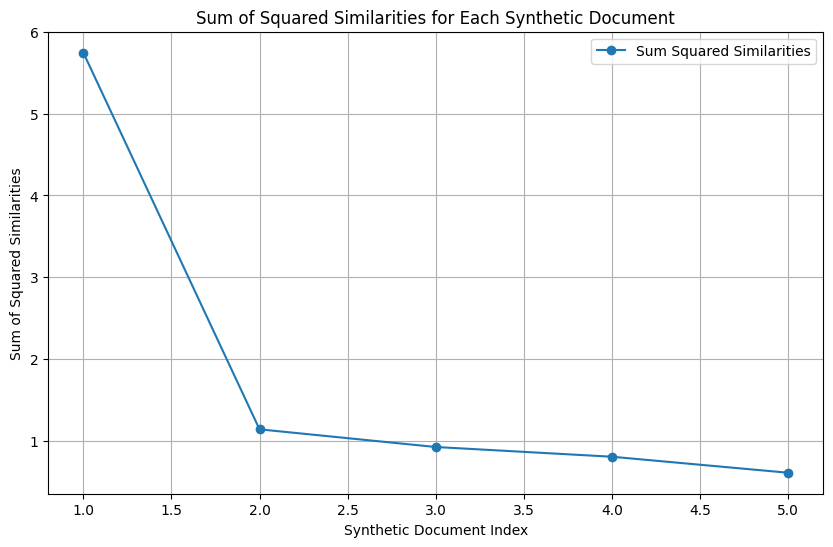

In [19]:
if __name__ == "__main__":
    plot_similarity_scores(normalized_td_matrix, synthetic_documents)

### Task 8: Plot Synthetic Documents

In [20]:
def project_documents_with_pca(original_docs, synthetic_docs, centroid_doc):
    """
    Project original, synthetic, and centroid documents into 2D using PCA.
    IN: original_docs, np.ndarray, matrix of original document vectors
        synthetic_docs, np.ndarray, matrix of synthetic document vectors
        centroid_doc, np.ndarray, the centroid document vector
    OUT: None
    """
    # Fit PCA on original documents
    pca = PCA(n_components=2)
    ori_2d = pca.fit_transform(original_docs)

    # Transform synthetic and centroid documents
    syn_2d = pca.transform(synthetic_docs)
    
    cent_2d = pca.transform(centroid_doc.reshape(1, -1))


    return ori_2d, syn_2d, cent_2d

In [21]:
def plot_documents(original_docs, synthetic_docs, centroid_doc):
    """
    Plot original, synthetic, and centroid documents in 2D using PCA.
    IN: original_docs, np.ndarray, matrix of original document vectors
        synthetic_docs, np.ndarray, matrix of synthetic document vectors
        centroid_doc, np.ndarray, the centroid document vector
    OUT: None
    """
    ori_2d, syn_2d, cent_2d = project_documents_with_pca(
        original_docs, synthetic_docs, centroid_doc
    )

    plt.figure(figsize=(12, 8))

    # Original documents
    plt.scatter(
        ori_2d[:, 0], ori_2d[:, 1],
        color="blue", alpha=0.6, label="Original Documents"
    )

    # Synthetic documents
    plt.scatter(
        syn_2d[:, 0], syn_2d[:, 1],
        color="red", marker="x", s=100, label="Synthetic Documents"
    )

    # Centroid
    plt.scatter(
        cent_2d[:, 0], cent_2d[:, 1],
        color="green", marker="*", s=200, label="Centroid Document"
    )

    # Labels for synthetic documents
    for i, (x, y) in enumerate(syn_2d):
        plt.text(x + 0.01, y + 0.01, f"Syn {i+1}", fontsize=12, color="black")

    plt.title("Document Visualization using PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

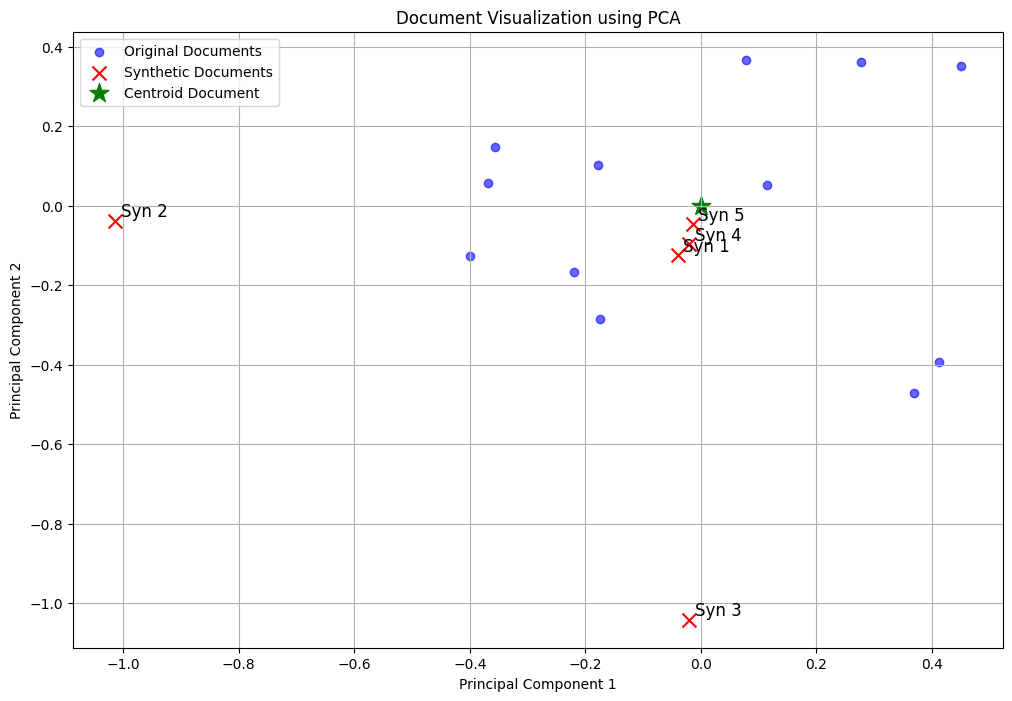

In [22]:
if __name__ == "__main__":
    plot_documents(normalized_td_matrix, synthetic_documents, centroid_document)